In [1]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import deepst.metrics as metrics
from deepst.datasets import BikeNYC
import math
import pickle
import time

Using TensorFlow backend.


test!


In [2]:
#import pylab as plt
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.
map_height, map_width = 16, 8  # grid size
nb_area = 81
m_factor = math.sqrt(1. * map_height * map_width / nb_area)
days_test = 10
T = 24
len_test = T * days_test
lr = 0.001  # learning rate
nb_epoch =40
nb_cont_epoch = 10
batch_size =32
seq_length=12
PATH_RESULT='Test_RET'
PATH_MODEL='Test_MODEL'
num_layers=3
test_data_nums =None

In [3]:
hyperparams_name = 'b{}.Conv2DLSTM_layers{}.SeqLen{}.Conv2D_LSTM_BikeNYC.lr{}'.format(
        batch_size, num_layers, seq_length, lr)

fname_param = os.path.join(PATH_MODEL, '{}.cont.best.h5'.format(hyperparams_name))

history_files = 'b{}.Conv2DLSTM_layers{}.SeqLen{}.Conv2D_LSTM_BikeNYC.lr{}'.format(
        batch_size, num_layers, seq_length, lr)

history_path = os.path.join(PATH_RESULT, '{}.cont.history.pkl'.format(hyperparams_name))

print(fname_param)
print(history_path)

Test_MODEL/b32.Conv2DLSTM_layers3.SeqLen12.Conv2D_LSTM_BikeNYC.lr0.001.cont.best.h5
Test_RET/b32.Conv2DLSTM_layers3.SeqLen12.Conv2D_LSTM_BikeNYC.lr0.001.cont.history.pkl


In [4]:
def build_model():
    seq = Sequential()
    
    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                       input_shape = (None, 2, map_height, map_width),
                       padding='same', activation='relu', return_sequences=True, data_format='channels_first'))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
         padding='same', activation='relu', return_sequences=True, data_format='channels_first'))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
         padding='same', activation='tanh', return_sequences=False, data_format='channels_first'))
    seq.add(BatchNormalization())

    seq.add(Conv2D(filters=2, kernel_size=(3, 3),
                   activation='tanh',
                   padding='same', data_format='channels_first'))

    adam = Adam(lr=lr)
    seq.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
    seq.summary()

    return seq

seq = build_model()
seq.load_weights(fname_param)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 32, 16, 8)   39296     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32, 16, 8)   32        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 32, 16, 8)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 32, 16, 8)   32        
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 32, 16, 8)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 16, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 16, 8)          578       
Total para

In [5]:
print('=' * 10)
print('Load cont.history.pkl File')
print()

with open(history_path, 'rb') as f:
    x = pickle.load(f)
    for k,v in x.items():
        print(k,v)
        print()

Load cont.history.pkl File

val_rmse [0.040628875022236242, 0.042930871572855599, 0.039519910387602088, 0.040782798143466976, 0.039633846119108043, 0.041066968094758474, 0.045675578531016947, 0.038425989835465101, 0.039401440854141823, 0.03937731933667947]

val_loss [0.0016600336508508539, 0.0018520916220867289, 0.0015706060525740948, 0.0016770269673441333, 0.0015837565504972866, 0.0017046765289056845, 0.0021289407924837841, 0.0014859167424212229, 0.0015646029433768814, 0.0015588805091053372]

loss [0.001584444220739683, 0.0015243477331833091, 0.001497171116049133, 0.001446424024161577, 0.0014401354646302561, 0.0013998799349128927, 0.0014779026352663848, 0.0014429745531777528, 0.0014228011152609609, 0.0013620163334633027]

rmse [0.039501081283583851, 0.038725387284320227, 0.038408796980483835, 0.037726770481623498, 0.037693885559367798, 0.037144143431370714, 0.038193684680633541, 0.037692526191127389, 0.037466407593543992, 0.036662036431069016]



In [6]:
print("loading data...")
X_train, Y_train, X_test, Y_test, X_timestamps, Y_timestamps, mmn = BikeNYC.load_sequence(seq_length=seq_length, T=24, 
                                    test_percent=0.055, data_numbers=test_data_nums)   
print('X_train shape is', X_train.shape)
print('Y_train shape is', Y_train.shape)
print('X_test shape is', X_test.shape)
print('Y_test shape is', Y_test.shape)

loading data...
incomplete days:  []
The length of dataseq is: 4392
min: 0.0 max: 267.0
X_data shape is (4380, 12, 2, 16, 8)
Y_data shape is (4380, 2, 16, 8)
X_train shape is (4139, 12, 2, 16, 8)
Y_train shape is (4139, 2, 16, 8)
X_test shape is (241, 12, 2, 16, 8)
Y_test shape is (241, 2, 16, 8)


In [28]:
start = time.clock()
print('evaluating using the model that has the best loss on the valid set')
score = seq.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0)
print('Train score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * m_factor))

elapsed = (time.clock() - start)
print("Time used on CPU:",elapsed)

evaluating using the model that has the best loss on the valid set
Train score: 0.001387 rmse (norm): 0.036914 rmse (real): 6.194902
Time used on CPU: 1093.461916


In [7]:
# Evaluate with batch_size=1
start = time.clock()
score = seq.evaluate(X_test, Y_test, batch_size=Y_test.shape[0], verbose=1)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * m_factor))

elapsed = (time.clock() - start)
print("Time used on CPU:",elapsed)

241/241 [==============================] - 22s
Test score: 0.001559 rmse (norm): 0.039483 rmse (real): 6.625970
Time used on CPU: 64.649894


In [17]:
# One-step predict for one sequence

print(X_test[1].shape)
print(np.expand_dims(Y_test[0], axis=0).shape)

start = time.clock()
score = seq.evaluate(np.expand_dims(X_test[1], axis=0), np.expand_dims(Y_test[1], axis=0), batch_size=1, verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * m_factor))
elapsed = (time.clock() - start)
print("Time used on CPU:",elapsed)

(12, 2, 16, 8)
(1, 2, 16, 8)
Test score: 0.000482 rmse (norm): 0.021957 rmse (real): 3.684753
Time used on CPU: 0.26977100000000576


In [84]:
# One-step predict for TWO sequence
print('batch_size is,', batch_size)
start = time.clock()
score = seq.evaluate(X_test[0:2], Y_test[0:2], batch_size=1, verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * m_factor))
elapsed = (time.clock() - start)
print("Time used on CPU:",elapsed)

batch_size is, 32
Test score: 0.000577 rmse (norm): 0.023933 rmse (real): 4.016504
Time used on CPU: 0.5396189999999024


(1, 2, 16, 8)
Inflow prediction:


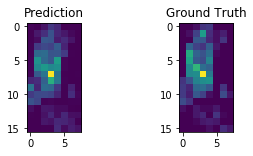

In [62]:
#visulization
%matplotlib inline

pred_nums=1
pred = seq.predict(np.expand_dims(X_test[0], axis=0))
print(pred.shape)
# show the predicion and groud truth
print('Inflow prediction:')
for i in range(pred_nums):
    fig = plt.figure(figsize=(5,2))
    ax = fig.add_subplot(121)
    ax.set_title('Prediction')
    ax.imshow(pred[0][0])
    ax = fig.add_subplot(122)
    ax.set_title('Ground Truth')
    ax.imshow(Y_test[0][0])

In [ ]:
# Multi-steps prediction